# Шавель 853501 Лабораторная работа № 3

Вариант 25. Имеется одноканальная СМО с очередью, ограниченной числом мест R = 2. На вход СМО поступает простейший по ток заявок с интенсивностью X. Время обслуживания распределено по обобщенному закону Эрланга с параметрами k, X2. Найти вероятности состояний СМО и характеристики эффективности СМО.

По сути, единственным отличием в реализации относительно прошлой лабораторной работы является замена закона распределения для времени обслуживания на закон Эрланга:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import heapq
import math
from collections import deque
from IPython.display import display, HTML

def sample(intensity):
    return np.random.exponential(1 / intensity)


def sample_erlang(shape, intensity):
    return np.random.gamma(shape, 1 / intensity)


class Action(Enum):
    REQUEST = 1
    SERVICE = 2
    LEAVE = 3
    

class Simulator:
    
    
    def __init__(self, channels_cnt, queue_size, rq_intensity, service_shape, service_intensity, leave_intensity):
        self.channels_cnt = channels_cnt
        self.queue_size = queue_size
        self.rq_intensity = rq_intensity
        self.service_shape = service_shape
        self.service_intensity = service_intensity
        self.leave_intensity = leave_intensity
    
    
    def get_product(self, limit):
        prod = 1
        beta = self.leave_intensity / self.service_intensity
        for l in range(1, limit + 1):
            prod *= self.channels_cnt + l * beta
        return prod
    
    
    def theoretical_probs(self):
        ro = self.rq_intensity / self.service_intensity
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        for i in range(self.channels_cnt + 1):
            state_probs[0] += (ro ** i) / math.factorial(i)
            
        sm = 0
        for i in range(1, self.queue_size + 1):
            sm += (ro ** i) / self.get_product(i)
        state_probs[0] += (ro ** self.channels_cnt) * sm / math.factorial(self.channels_cnt)
        state_probs[0] = state_probs[0] ** (-1)
        for i in range(1, self.channels_cnt + 1):
            state_probs[i] = state_probs[0] * (ro ** i) / math.factorial(i)
        for i in range(1, self.queue_size + 1):
            prod = self.get_product(i)
            state_probs[self.channels_cnt + i] = state_probs[self.channels_cnt] * (ro ** i) / prod
        return state_probs
    

    def request(self, rq_id):
        if self.used_channels_cnt < self.channels_cnt:
            self.used_channels_cnt += 1
            heapq.heappush(self.events,
                           (self.current_time + 
                            sample_erlang(self.service_shape, self.service_intensity),
                           Action.SERVICE, 
                           rq_id))
        elif len(self.current_queue) < self.queue_size:
            self.current_queue.append(rq_id)
        else:
            pass
        
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, 
                                     Action.REQUEST, 
                                     self.current_rq_id))
        heapq.heappush(self.events, (rq_time + sample(self.leave_intensity), 
                                     Action.LEAVE, 
                                     self.current_rq_id))
        self.current_rq_id += 1
        
        
    def service(self, rq_id):
        if len(self.current_queue) == 0:
            self.used_channels_cnt -= 1
        else:
            heapq.heappush(self.events, (self.current_time + 
                                         sample_erlang(self.service_shape, self.service_intensity),
                                         Action.SERVICE,
                                         self.current_queue.popleft()))
            
    
    def leave(self, rq_id):
        if self.current_queue.count(rq_id):
            self.current_queue.remove(rq_id)
        
        
    def apply(self, action, rq_id):
        if action == Action.REQUEST:
            self.request(rq_id)
        elif action == Action.SERVICE:
            self.service(rq_id)
        elif action == Action.LEAVE:
            self.leave(rq_id)
            
            
    def run(self, total_time):
        self.used_channels_cnt = 0
        self.current_queue = deque()
        self.events = []
        self.current_time = 0
        self.total_time = total_time
        self.current_rq_id = 0
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, Action.REQUEST, 0))
        heapq.heappush(self.events, (rq_time + sample(self.leave_intensity), Action.LEAVE, 0))
        self.current_rq_id += 1
        while (self.events):
            item = heapq.heappop(self.events)
            passed_time = item[0] - self.current_time
            state = self.used_channels_cnt + len(self.current_queue)
            state_probs[state] += passed_time / self.total_time;
            self.current_time = item[0]
            if (self.current_time > self.total_time):
                break
            self.apply(item[1], item[2])
            
        passed_time = total_time - self.current_time
        state = self.used_channels_cnt + len(self.current_queue)
        state_probs[state] += passed_time / self.total_time;
        return state_probs
    
    
    def get_features(self, state_probs):
        ro = self.rq_intensity / self.service_intensity
        features = dict()
        p_reject = state_probs[self.channels_cnt] * (ro ** self.queue_size) / self.get_product(self.queue_size)
        Q = 1 - p_reject
        A = self.rq_intensity * Q
        avg_rq_smo = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_rq_smo += state_probs[i] * i
        avg_rq_queue = 0
        for i in range(self.channels_cnt + 1, self.channels_cnt + self.queue_size + 1):
            avg_rq_queue += state_probs[i] * (i - self.channels_cnt)
        avg_channels_used = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_channels_used += state_probs[i] * min(self.channels_cnt, i)
        avg_t_queue = avg_rq_queue / self.rq_intensity
        avg_t_smo = avg_t_queue + Q / self.service_intensity
        return [A, p_reject, avg_rq_smo, avg_rq_queue, avg_t_smo, avg_t_queue, avg_channels_used]

    
    def full_compare(self):
        theor_state_prob = self.theoretical_probs()
        emp_state_prob = self.run(30000)
        data = {'Теор. вероятности состояний с эксп. распределением': theor_state_prob.tolist(), 
                'Эмпир. вероятности состояний': emp_state_prob.tolist()}
        df = pd.DataFrame(data)
        display(df)
        df.plot(kind='bar')
        plt.show()
        theor_features = self.get_features(theor_state_prob)
        emp_features = self.get_features(emp_state_prob)
        indices = ['Абсолютная пропускная способность',
                  'Вероятность отказа',
                  'Среднее количество заявок в СМО',
                  'Среднее количество заявок в очереди',
                  'Среднее время нахождения заявки в СМО',
                  'Среднее время нахождения заявки в очереди',
                  'Среднее количество используемых каналов']
        df_features = pd.DataFrame({'Теор. показатели с эксп. распределением':theor_features,
                                    'Эмп. показатели':emp_features}, 
                                   index=indices)
        display(df_features)
        

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.135906,0.137667
1,0.226510,0.225915
2,0.302013,0.302966
3,0.335570,0.333452


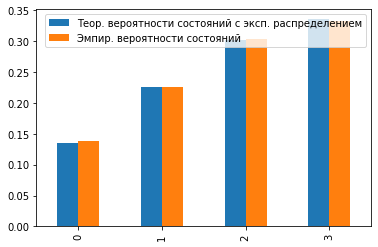

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.221477,0.221770
Вероятность отказа,0.335570,0.334689
Среднее количество заявок в СМО,1.837248,1.832204
Среднее количество заявок в очереди,0.973154,0.969871
Среднее время нахождения заявки в СМО,6.241611,6.236169
Среднее время нахождения заявки в очереди,2.919463,2.909613
Среднее количество используемых каналов,0.864094,0.862333


In [12]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/5,
              leave_intensity=1/20)
sim.full_compare()

Далее иследуем СМО при различных значениях тех параметров, которые не зафиксированы условием задачи:

Попробуем изменить параметр распределния Эрланга (service_shape). По логике, при его увеличении должно увеличиться среднее время на обслуживание, т.к. распределение Эрланга с параметром k, характеризует время ожидания до того, как в Пуассоновском потоке событие произойдет k раз. Протестируем симуляцией:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.135906,0.026813
1,0.226510,0.128873
2,0.302013,0.329756
3,0.335570,0.514558


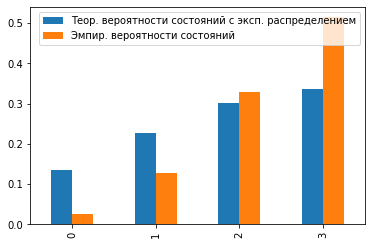

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.221477,0.269692
Вероятность отказа,0.335570,0.190923
Среднее количество заявок в СМО,1.837248,2.332058
Среднее количество заявок в очереди,0.973154,1.358871
Среднее время нахождения заявки в СМО,6.241611,8.121997
Среднее время нахождения заявки в очереди,2.919463,4.076614
Среднее количество используемых каналов,0.864094,0.973187


In [13]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/5,
              leave_intensity=1/20)
sim.full_compare()

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.135906,0.006260
1,0.226510,0.077922
2,0.302013,0.287528
3,0.335570,0.628290


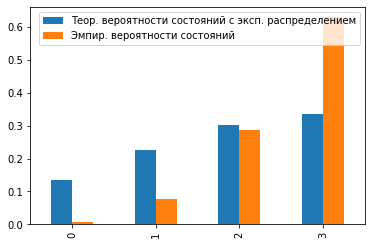

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.221477,0.294853
Вероятность отказа,0.335570,0.115440
Среднее количество заявок в СМО,1.837248,2.537848
Среднее количество заявок в очереди,0.973154,1.544108
Среднее время нахождения заявки в СМО,6.241611,9.055124
Среднее время нахождения заявки в очереди,2.919463,4.632324
Среднее количество используемых каналов,0.864094,0.993740


In [14]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/5,
              leave_intensity=1/20)
sim.full_compare()

Как можно заметить, вероятности сдвигаются больше в правую сторону, т.е. очередь плотнее заполняется, что и потверждает нашу гипотезу. Далее попробуем увеличить второй параметр закона Эрланга, по сути интенсивность:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.282609,0.277819
1,0.282609,0.286395
2,0.245747,0.245750
3,0.189036,0.190036


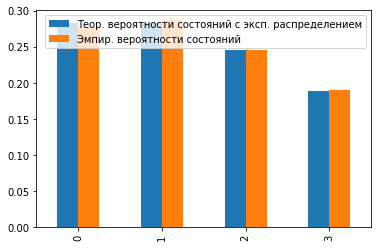

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.270321,0.269477
Вероятность отказа,0.189036,0.191568
Среднее количество заявок в СМО,1.341210,1.348003
Среднее количество заявок в очереди,0.623819,0.625822
Среднее время нахождения заявки в СМО,4.304348,4.302761
Среднее время нахождения заявки в очереди,1.871456,1.877466
Среднее количество используемых каналов,0.717391,0.722181


In [15]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/3,
              leave_intensity=1/20)
sim.full_compare()

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.435697,0.435578
1,0.290465,0.286992
2,0.176039,0.178196
3,0.097800,0.099235


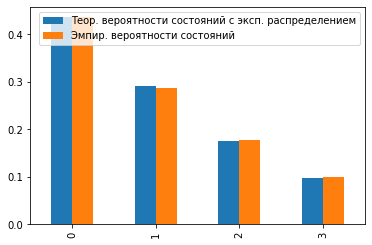

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.300733,0.301123
Вероятность отказа,0.097800,0.096630
Среднее количество заявок в СМО,0.935941,0.941088
Среднее количество заявок в очереди,0.371638,0.376665
Среднее время нахождения заявки в СМО,2.919315,2.936736
Среднее время нахождения заявки в очереди,1.114914,1.129996
Среднее количество используемых каналов,0.564303,0.564422


In [16]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/2,
              leave_intensity=1/20)
sim.full_compare()

В данном случае, очередь становится более свободной, что логично, так как мы увеличивали интенсивность обслуживания. Далее попробуем увеличить оба параметра одновременно:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.282609,0.075929
1,0.282609,0.212264
2,0.245747,0.342969
3,0.189036,0.368838


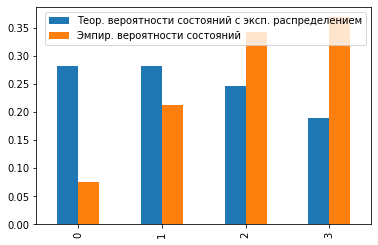

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.270321,0.286006
Вероятность отказа,0.189036,0.141983
Среднее количество заявок в СМО,1.341210,2.004717
Среднее количество заявок в очереди,0.623819,1.080645
Среднее время нахождения заявки в СМО,4.304348,5.815988
Среднее время нахождения заявки в очереди,1.871456,3.241936
Среднее количество используемых каналов,0.717391,0.924071


In [17]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/3,
              leave_intensity=1/20)
sim.full_compare()

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.435697,0.029721
1,0.290465,0.149619
2,0.176039,0.358990
3,0.097800,0.461669


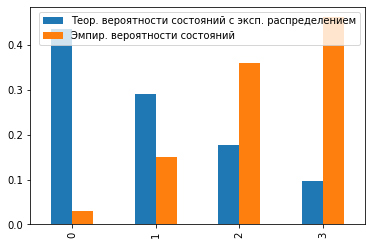

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.300733,0.316541
Вероятность отказа,0.097800,0.050377
Среднее количество заявок в СМО,0.935941,2.252607
Среднее количество заявок в очереди,0.371638,1.282329
Среднее время нахождения заявки в СМО,2.919315,5.746232
Среднее время нахождения заявки в очереди,1.114914,3.846986
Среднее количество используемых каналов,0.564303,0.970279


In [18]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/2,
              leave_intensity=1/20)
sim.full_compare()

В целом, можно наблюдать, что параметры компенсируют друг друга в каком-то смысле, однако первый все-таки имеет больший эффект, так как вероятности немного сдвигаются вправо. Далее попробуем уменшить интенсивность потока заявок:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.627376,0.116054
1,0.250951,0.280570
2,0.091255,0.349699
3,0.030418,0.253677


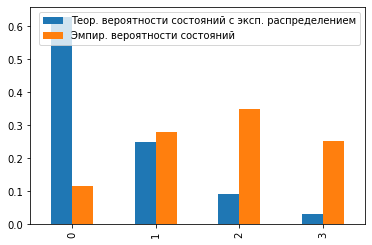

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.193916,0.193198
Вероятность отказа,0.030418,0.034008
Среднее количество заявок в СМО,0.524715,1.740999
Среднее количество заявок в очереди,0.152091,0.857053
Среднее время нахождения заявки в СМО,2.699620,6.217250
Среднее время нахождения заявки в очереди,0.760456,4.285267
Среднее количество используемых каналов,0.372624,0.883946


In [19]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/5,
              service_shape=4,
              service_intensity=1/2,
              leave_intensity=1/20)
sim.full_compare()

Вполне логично, система лучше справляется с обработкой. И в конце, попробуем уменьшить предельное время ожидания заявок в очереди:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.642623,0.207124
1,0.257049,0.397261
2,0.079971,0.271580
3,0.020356,0.124035


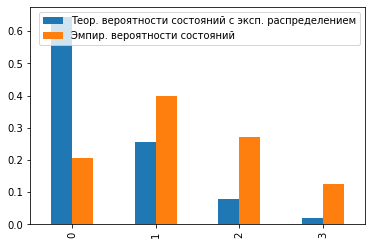

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.195929,0.193708
Вероятность отказа,0.020356,0.031460
Среднее количество заявок в СМО,0.478060,1.312526
Среднее количество заявок в очереди,0.120683,0.519650
Среднее время нахождения заявки в СМО,2.562704,4.535329
Среднее время нахождения заявки в очереди,0.603417,2.598249
Среднее количество используемых каналов,0.357377,0.792876


In [20]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/5,
              service_shape=4,
              service_intensity=1/2,
              leave_intensity=1/7)
sim.full_compare()

Как и можно было ожидать, очередь стала более свободной, среднее кол-во заявок в ней уменьшилось